In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import collections

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# Timeline

In [4]:
_ = (
    pd.read_csv(
        'rehydrated_tweets_count_by_day.csv',
        parse_dates=['day'],
        index_col=['day', 'lang']
   )
    ['count']
    .unstack('lang', fill_value=0)
)

_['total'] = _.sum(axis=1)
_ = _[['lv', 'ru', 'en', 'total']]

timeline = _

In [5]:
timeline.head()

lang,lv,ru,en,total
day,,,,
2017-04-15,1304,361,133,1957
2017-04-16,1462,327,185,2190
2017-04-17,1353,284,178,1990
2017-04-18,2767,376,315,3646
2017-04-19,3134,443,312,4118


In [6]:
'Average tweet number per day: {:.0f}'.format(timeline['total'].mean())

'Average tweet number per day: 3151'

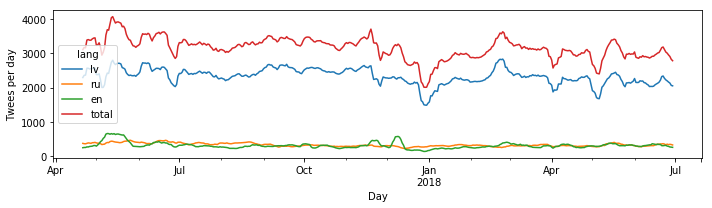

In [7]:
_ = (
    timeline
    .rolling(window=7).mean()
    .plot(figsize=(10, 3))
)

_.set(xlabel='Day', ylabel='Twees per day')


_.figure.tight_layout()
_.figure.savefig('rehydrated_tweets_count_by_day.pdf')

# Source statistics

In [8]:
sources = (
    pd.read_csv(
        'rehydrated_tweets_source_counts.csv',
        index_col=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
        ],
        usecols=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
            'source_lang_count', 'source_lang_share'
        ],
    )
    .unstack('lang', fill_value=0)
)

In [9]:
sources = (
    sources.reorder_levels([1, 0], axis=1)
    .reset_index()
    .set_index('source_pretty').sort_values('total_count', ascending=False)[
        [
            'total_count', 'total_share', 'tracked_source_share',
            'lv', 'ru', 'en',
            'other_lang_count', 'other_lang_share',
        ]
    ]
    .sort_values('total_count', ascending=False)
)

In [10]:
sources

lang                total_count total_share tracked_source_share  \
                                                                   
source_pretty                                                      
Twitter Web Client       476426       34.3%                52.1%   
Twitter for Android      230513       16.6%                 8.3%   
Twitter for iPhone       208140       15.0%                14.2%   
TweetDeck                106090        7.6%                91.8%   
TVNET Login               58916        4.2%                96.7%   
dlvr.it                   46194        3.3%                98.4%   
Facebook                  37056        2.7%                95.1%   
Foursquare                31117        2.2%                 0.0%   
Instagram                 24960        1.8%                 1.8%   
SKATIES                   23351        1.7%                98.0%   

lang                               lv                                  ru  \
                    source_lang_count source_lang_share source_lang_count   
source_pretty                                                               
Twitter Web Client             393264             82.5%             15364   
Twitter for Android            156770             68.0%             22851   
Twitter for iPhone             125993             60.5%             33298   
TweetDeck                      103974             98.0%                75   
TVNET Login                     26734             45.4%             31482   
dlvr.it                         45655             98.8%               136   
Facebook                        14019             37.8%             21264   
Foursquare                      24600             79.1%               219   
Instagram                        8881             35.6%              2463   
SKATIES                         23334             99.9%                 0   

lang                                                 en                    \
                    source_lang_share source_lang_count source_lang_share   
source_pretty                                                               
Twitter Web Client               3.2%             39711              8.3%   
Twitter for Android              9.9%             33621             14.6%   
Twitter for iPhone              16.0%             32293             15.5%   
TweetDeck                        0.1%              1497              1.4%   
TVNET Login                     53.4%                23              0.0%   
dlvr.it                          0.3%               130              0.3%   
Facebook                        57.4%               455              1.2%   
Foursquare                       0.7%              1894              6.1%   
Instagram                        9.9%              8323             33.3%   
SKATIES                             0                 0                 0   

lang                other_lang_count other_lang_share  
                                                       
source_pretty                                          
Twitter Web Client             28087             5.9%  
Twitter for Android            17271             7.5%  
Twitter for iPhone             16556             8.0%  
TweetDeck                        544             0.5%  
TVNET Login                      677             1.1%  
dlvr.it                          273             0.6%  
Facebook                        1318             3.6%  
Foursquare                      4404            14.2%  
Instagram                       5293            21.2%  
SKATIES                           17             0.1%

In [11]:
sources.to_latex('figures/rehydrated_tweets_source_counts.tex')

# Users

In [12]:
rehydrated_tweets_user_tweet_count = pd.read_csv('rehydrated_tweets_user_tweet_count.csv', squeeze=True)

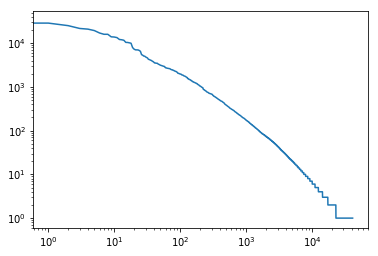

In [13]:
rehydrated_tweets_user_tweet_count.plot.line(logx=True, logy=True);

In [14]:
_total = rehydrated_tweets_user_tweet_count.shape[0]
_at_least_50 = (rehydrated_tweets_user_tweet_count >= 50).sum()
print(
    f'Total users: {_total}\n'
    f'Users with at least 50 tweets: {_at_least_50} ({{:.1%}})'.format(_at_least_50 / _total)
)

Total users: 41304
Users with at least 50 tweets: 2772 (6.7%)


In [15]:
active_tweets = rehydrated_tweets_user_tweet_count[rehydrated_tweets_user_tweet_count >= 50].sum()
total_tweets = rehydrated_tweets_user_tweet_count.sum()
assert timeline['total'].sum() == total_tweets
_ = active_tweets / total_tweets
f'Total tweets by active users: {active_tweets}, {_:.1%}. Total tweets: {total_tweets}'

'Total tweets by active users: 1202823, 86.6%. Total tweets: 1389538'

# Language usage 

In [16]:
rehydrated_tweets_language_counts = (
    pd.read_csv('rehydrated_tweets_language_counts.csv', index_col='lang')
)

In [17]:
rehydrated_tweets_language_counts

,count
lang,
en,136738
lv,1027194
ru,145718


In [18]:
(
    (rehydrated_tweets_language_counts / timeline['total'].sum())
    .style.format({'count': '{:.1%}'})
)

,count
lang,
en,9.8%
lv,73.9%
ru,10.5%


In [19]:
_ = (timeline['total'].sum() - rehydrated_tweets_language_counts.sum())[0]

__ = _ / rehydrated_tweets_language_counts.sum()[0]
f'{_}, {__:.1%}'

'79888, 6.1%'

In [20]:
_ = pd.read_csv('rehydrated_tweets_lang_usage.csv', index_col='rnum')

_['Language Uniformity Score'] = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

lang_usage = _

In [21]:
'Users with at least 50 users (should match the value above): {}'.format(lang_usage.shape[0])

'Users with at least 50 users (should match the value above): 2772'

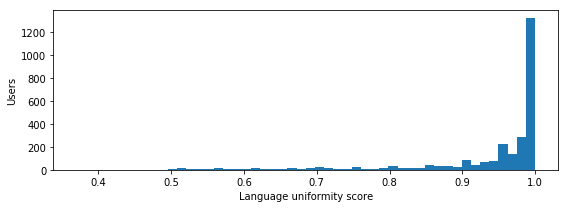

In [22]:
_ = lang_usage['Language Uniformity Score'].plot.hist(bins=50, figsize=(8, 3))

_.set(xlabel="Language uniformity score", ylabel="Users")
_.figure.tight_layout()

_.figure.savefig('rehydrated_tweets_lang_usage.pdf')

In [23]:
_ = pd.read_csv(
    'milajevs-bucc17-screen_names-languages.csv',
    index_col='Screen name',
    usecols=['Screen name', 'Latvian', 'Russian', 'English'],
).fillna(0).astype(int)

_.columns = ['lv', 'ru', 'en']

bucc17_uniformity_score = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

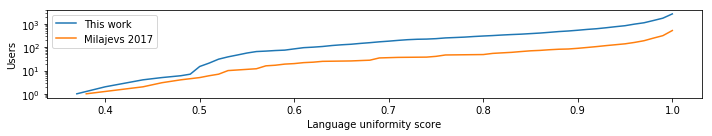

In [24]:
_ = (
    lang_usage['Language Uniformity Score'].value_counts().sort_index().cumsum().rename('This work')
    .plot(logx=False, logy=True, figsize=(10, 2), legend=True)
)

bucc17_uniformity_score.value_counts().sort_index().cumsum().rename('Milajevs 2017').plot(legend=True)

_.set(xlabel='Language uniformity score', ylabel='Users')
_.figure.tight_layout()

_.figure.savefig('uniformity_score.pdf')

In [25]:
lang_usage.sort_values('Language Uniformity Score').head()

,lv,ru,en,total,Language Uniformity Score
rnum,,,,,
2013,13,16,14,74,0.37
1597,16,20,14,97,0.40
453,78,137,93,441,0.44
2380,26,8,25,60,0.44
826,48,76,43,220,0.46


# Language preference

## Monolingual

In [26]:
monolingual = (
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] == 0).sum(axis='columns') == 2
    ]
    [['lv', 'ru', 'en']] > 0
).sum(axis='rows')

In [27]:
'Monoligual users: {}'.format(monolingual.sum())

'Monoligual users: 794'

In [28]:
pd.DataFrame(
    {
        'count': monolingual,
        'share': (monolingual / monolingual.sum()).round(3),
    }
)

,count,share
lv,640,0.806
ru,40,0.050
en,114,0.144


## Multilingual

In [29]:
(
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] > 0).sum(axis='columns') > 1
    ]
    [['lv', 'ru', 'en']]
    .replace(0, np.nan)
    .rank(axis='columns', method='min', ascending=False)
    .apply(lambda c: c.value_counts(), axis='rows')
)

,lv,ru,en
1.0,1496,222,252
2.0,298,163,1550
3.0,76,228,96


# Topics

In [30]:
relevance_judgments_count_by_day = (
    pd.read_csv(
        'relevance_judgments_count_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )['count']
    .unstack('topic_id', fill_value=0)
)

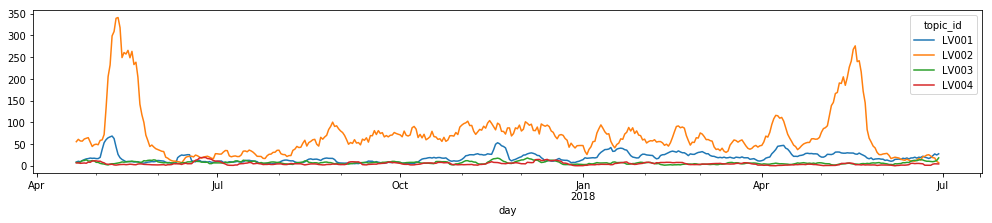

In [31]:
(
    relevance_judgments_count_by_day[
        ['LV001', 'LV002', 'LV003', 'LV004']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

In [32]:
_ = (
    pd.read_csv(
        'relevance_judgments_lang_pref_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )
)

_.columns = pd.MultiIndex.from_tuples(
    [
        ('Counts', 'Total'),
        ('Counts', 'lv, ru, en'),

        ('Tweets', 'lv'),
        ('Tweets', 'ru'),
        ('Tweets', 'en'),

        ('Users', 'lv'),
        ('Users', 'ru'),
        ('Users', 'en'),
    ],
    names=['Type', 'Language']
)
relevance_judgments_lang_pref_by_day = _

In [33]:
relevance_judgments_lang_pref_by_day.head()

Type                Counts            Tweets           Users           
Language             Total lv, ru, en     lv   ru   en    lv   ru    en
day        topic_id                                                    
2017-04-16 LV001         8          8    1.0  0.0  0.0  0.99  0.0  0.01
2017-04-17 LV001         1          1    1.0  0.0  0.0  0.81  0.0  0.19
2017-04-18 LV001        12         12    1.0  0.0  0.0  0.98  0.0  0.02
2017-04-19 LV001        15         15    1.0  0.0  0.0  0.88  0.0  0.12
2017-04-20 LV001        11         10    1.0  0.0  0.0  1.00  0.0  0.00

In [34]:
relevance_judgments_lang_pref_by_day['Counts', 'Total'].groupby(level='topic_id').sum()

topic_id
LV001     7404
LV002    26628
LV003     3017
LV004     2059
LV005     7396
LV006     9364
LV007     1476
LV008     1204
LV009     2190
LV010      968
LV011      940
LV012     3476
LV013     1389
LV014      479
LV015      197
LV016      209
Name: (Counts, Total), dtype: int64

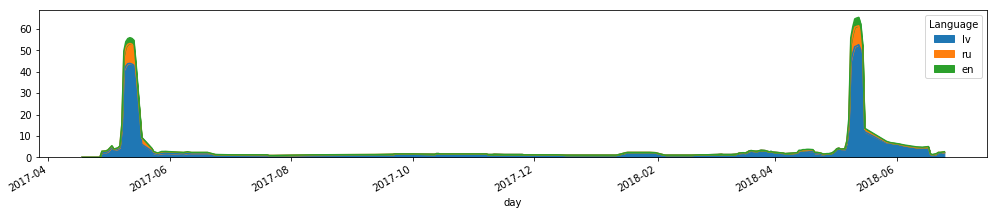

In [35]:
_ = relevance_judgments_lang_pref_by_day.loc[(slice(None), 'LV008'), :].reset_index('topic_id')

(
    _['Users']
    .multiply(
        _['Counts', 'lv, ru, en'],
        axis='rows',
    )
    .rolling(window=7).mean()
    .plot.area(figsize=(17, 3))
);

## Topics 2

In [36]:
_ = pd.read_csv(
    'relevance_judgments_lang_pref.csv',
    index_col=['topic_id', 'day', 'tweet_lang'],
    parse_dates=['day']
)

relevance_judgments_lang_pref = _

In [37]:
relevance_judgments_lang_pref.loc[['LV001']].head()

r_lv  r_ru  r_en
topic_id day        tweet_lang                  
LV001    2018-01-24 lv          0.66  0.01  0.33
         2018-02-18 und         0.66  0.01  0.33
         2018-02-19 lv          0.66  0.01  0.33
         2018-02-26 lv          0.66  0.01  0.33
         2018-02-27 lv          0.66  0.01  0.33

In [38]:
_ = (
    relevance_judgments_lang_pref
    .groupby(level=['topic_id', 'tweet_lang']).size()
    .unstack('tweet_lang', fill_value=0)
    [['lv', 'ru', 'en']]
)

_total = _.sum(axis='columns')

__ = _.divide(_total, axis='rows')

__['total'] = _total
__.style.format({'lv': '{:.1%}', 'ru': '{:.1%}', 'en': '{:.1%}'})

__.to_latex('figures/topic_lang_counts.tex', float_format='{:.1%}'.format)

__

tweet_lang,lv,ru,en,total
topic_id,,,,
LV001,0.872929,0.017938,0.109133,7303
LV002,0.947391,0.024918,0.027691,25604
LV003,0.891398,0.068416,0.040186,3011
LV004,0.853944,0.046251,0.099805,2054
LV005,0.935379,0.041135,0.023486,7366
LV006,0.862332,0.098012,0.039656,9305
LV007,0.797390,0.015110,0.187500,1456
LV008,0.848739,0.128571,0.022689,1190
LV009,0.870953,0.079093,0.049954,2162


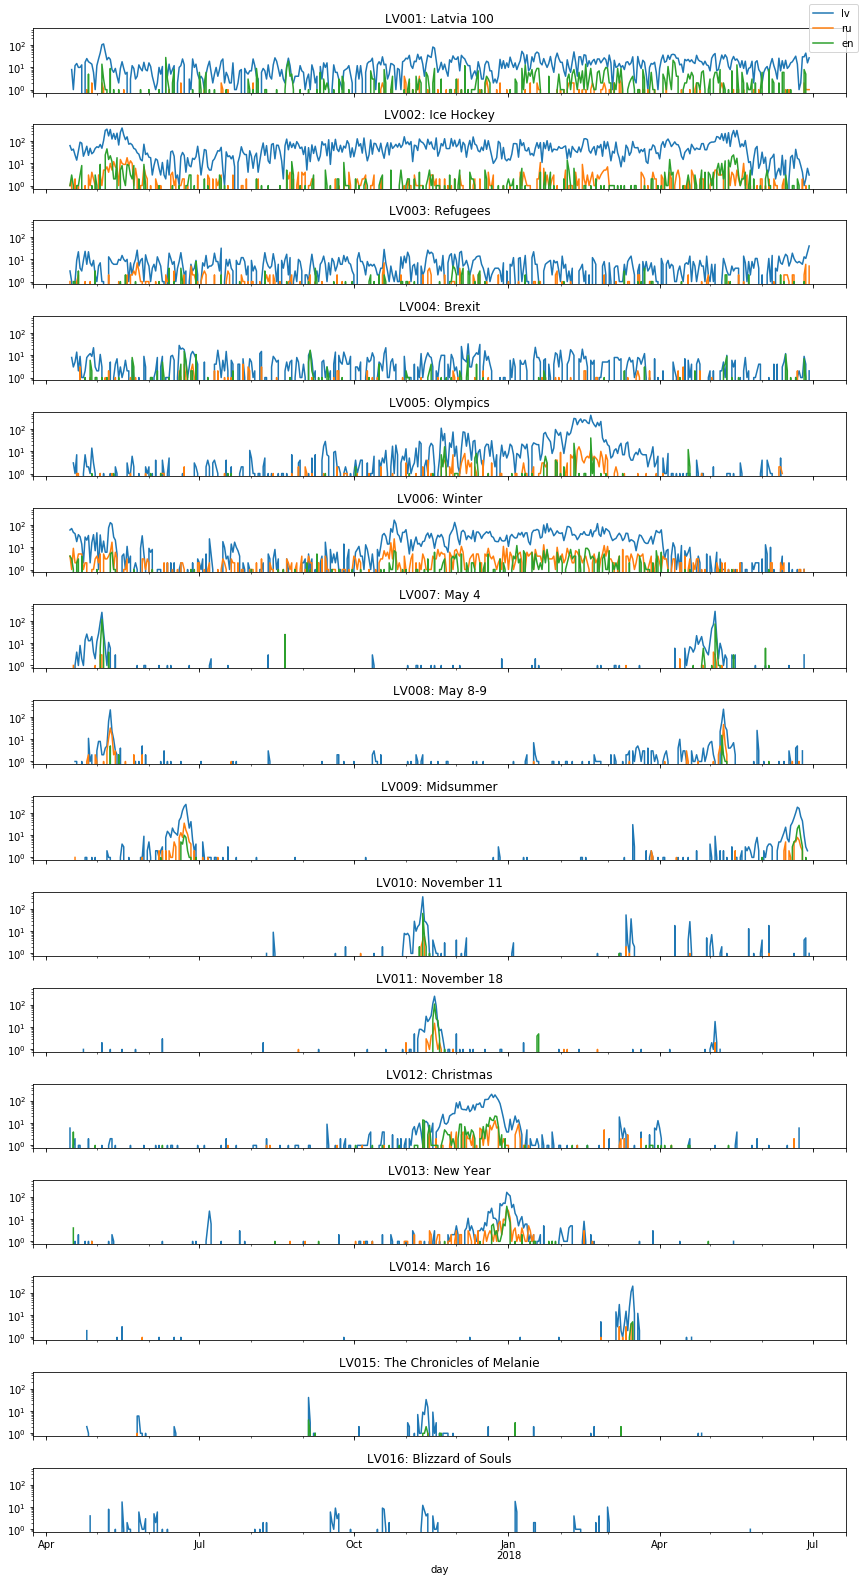

In [39]:
_data = (
    relevance_judgments_lang_pref
    .groupby(level=['topic_id', 'day' ,'tweet_lang']).size()
    .unstack('tweet_lang', fill_value=0)
    [['lv', 'ru', 'en']]
)


topics = collections.OrderedDict(
    [

        ('LV001', 'Latvia 100'),
        ('LV002', 'Ice Hockey'),
        ('LV003', 'Refugees'),
        ('LV004', 'Brexit'),
        ('LV005', 'Olympics'),

        ('LV006', 'Winter'),

        ('LV007', 'May 4'),
        ('LV008', 'May 8-9'),
        ('LV009', 'Midsummer'),
        ('LV010', 'November 11'),
        ('LV011', 'November 18'),
        ('LV012', 'Christmas'),
        ('LV013', 'New Year'),
        ('LV014', 'March 16'),

        ('LV015', 'The Chronicles of Melanie'),
        ('LV016', 'Blizzard of Souls'),
 
     ]
)

fig, axs = plt.subplots(len(topics), 1, sharex=True, sharey=True, figsize=(12, 22))

axs = axs.flatten()


for (topic, topic_title), ax in zip (topics.items(), axs):

    _ = (
        _data.loc[topic]
        .resample('1d', level='day').sum()
        .plot.line(ax=ax, logy=True, legend=False, title=f'{topic}: {topic_title}')
    );

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

fig.tight_layout()
fig.savefig('topic_timeline.pdf')

# Topic overlap

In [40]:
relevance_judgments_topic_overlap = (
    pd.read_csv('relevance_judgments_topic_overlap.csv')
    .groupby(['topic1', 'title1', 'topic2']).size().unstack('topic2', fill_value='')
)

In [41]:
relevance_judgments_topic_overlap

,topic2,LV001,LV002,LV003,LV004,LV005,LV006,LV007,LV008,LV009,LV010,LV011,LV012,LV013,LV014,LV015,LV016
topic1,title1,,,,,,,,,,,,,,,,
LV001,Latvia 100,8385,17,13,,29,2,134,18,14,26,59,7,6,,8,4
LV002,Ice Hockey,,30664,,,395,25,38,1,7,12,2,32,9,,,
LV003,Refugees,,,3209,30,,,,,2,,,11,1,,,
LV004,Brexit,,,,2161,,1,,,,,,,2,,,
LV005,Olympics,,,,,8572,13,,,,,,2,,,,
LV006,Winter,,,,,,10510,1,6,6,,10,236,42,,,
LV007,May 4,,,,,,,1863,8,,2,6,,,,,
LV008,May 8-9,,,,,,,,1386,1,1,,,,4,,
LV009,Midsummer,,,,,,,,,2595,,,3,1,1,,
